Populating the interactive namespace from numpy and matplotlib


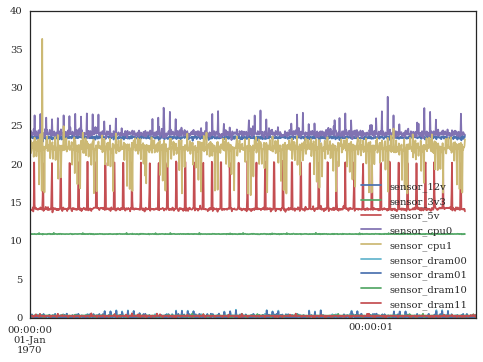

In [1]:
%pylab inline
import seaborn as sns
import pandas as pd
from powervisualisation import Trace
from __future__ import division

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

T = Trace("data/AdeptDataForPatrick/multiscale/1/kernel_fileparse_none_float_size_3000000_reps_1.hdf5")
df = T.power_as_df()

df.plot()

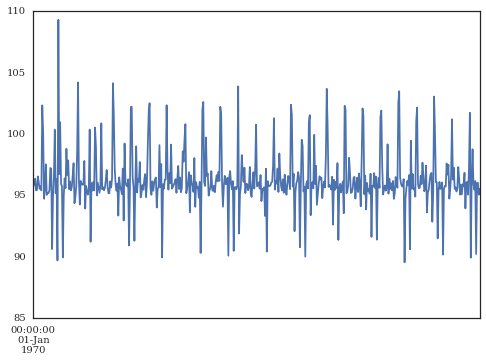

In [3]:
signal = df.sum(axis=1).ix[:500]
    
signal.plot()

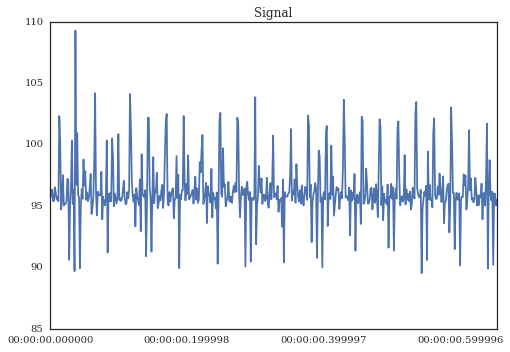

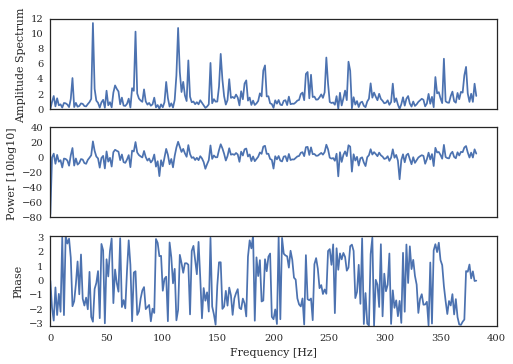

In [4]:
def power_spectrum(df):
    dt = (df.index[1] - df.index[0]).total_seconds()
    y = df.values - np.mean(df.values)
    
    plt.plot(df.index, df.values)
    plt.title("Signal")
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    
    Y    = numpy.fft.rfft(y, norm="ortho")
    freq = numpy.fft.rfftfreq(len(y), dt)
    ax1.plot( freq, numpy.abs(Y))
    ax2.plot( freq, 10 * np.log10(numpy.abs(Y)**2))
    ax3.plot(freq, numpy.angle(Y))
    
    ax3.set_ylim((-np.pi, np.pi))
    
    ax3.set_xlabel("Frequency [Hz]")
    
    ax1.set_ylabel("Amplitude Spectrum")
    ax2.set_ylabel("Power [10log10]")
    ax3.set_ylabel("Phase")
    
# Total Power from one of the benchmark runs
power_spectrum(signal)

In [5]:
x = np.linspace(0, 5 * np.pi, 100000)
y = np.sin(x) + 3 * np.cos(2*x)  # f(x) = sin x + 3 cos 2x  in [0, 5pi]
df = pd.Series(y, index= pd.DatetimeIndex(start=0, freq="1 us", periods=len(y)))

#df.plot()
#power_spectrum(df)

In [20]:
import matplotlib.pylab as plt
from matplotlib.mlab import find
import numpy as np

def freq_crossings(data):
    dt = (data.index[1] - data.index[0]).total_seconds()
    
    demeaned = data.values - np.nanmean(data.values)
    crossing_freq = len(find((demeaned[1:] >= 0) & (demeaned[:-1] < 0))) / len(data)
    return 1 / (dt * crossing_freq)

freq_crossings(signal)

3534.0684195646027

In [6]:
from numpy.fft import rfft
from numpy import argmax, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_fft(sig, fs=1.0):
    """
    Estimate frequency from peak of FFT
    """
    
    
    # Compute Fourier transform of windowed signal
    windowed = sig * blackmanharris(len(sig))
    f = rfft(windowed)

    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f))  # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]

    # Convert to equivalent frequency
    return fs * true_i / len(windowed)


freq_fft(signal.values)

0.00089183107297786707

In [49]:
from scipy.signal import blackmanharris, fftconvolve
def freq_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation (same thing as convolution, but with
    # one input reversed in time), and throw away the negative lags
    corr = fftconvolve(sig, sig[::-1], mode='full')
    corr = corr[len(corr)//2:]

    # Find the first low point
    d = diff(corr)
    start = find(d > 0)[0]

    # Find the next peak after the low point (other than 0 lag).  This bit is
    # not reliable for long signals, due to the desired peak occurring between
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

freq_autocorr(df["sensor_5v"].values, 1.0)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [52]:
s5v = df["sensor_5v"]

7.6351138933739469

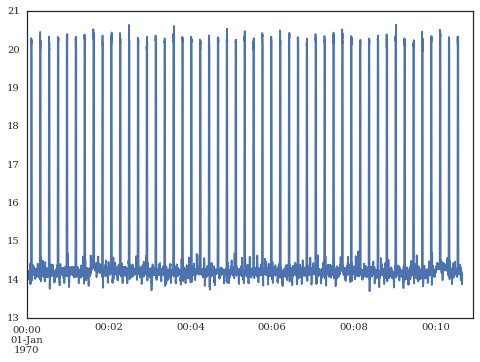

In [98]:
import matplotlib.pylab as plt
from matplotlib.mlab import find
import numpy as np

def freq_crossings(data, dt=None):
    """
    Calculates frequency of a signal by de-meaning and counting zero crossings.
    :param data: pd.Series
    :param dt: time in second between two points in signal
    :return: frequency in Hz
    """
    if dt is None:
        dt = (data.index[-1] - data.index[0]).total_seconds() / len(data.index)
    
    demeaned = data - data.mean()
    num_crossings = ((demeaned < 0) &  (demeaned >= 0)).count()
    
    crossing_freq = num_crossings / len(data)
    return 1 / (crossing_freq * dt)
    
s5v.plot()
freq_crossings(s5v)

0.130973815711 100 13


(7.6351138933739469, 0.087759929808895937)

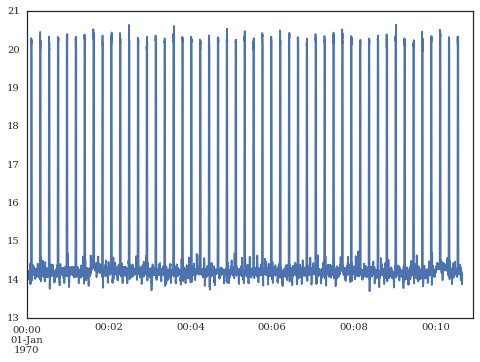

In [148]:
import matplotlib.pylab as plt
from matplotlib.mlab import find
import numpy as np

def freq_autocorr(data, dt=None):
    """
    Calculates frequency of a signal by de-meaning and counting zero crossings.
    :param data: pd.Series
    :param dt: time in second between two points in signal
    :return: frequency in Hz
    """
    if dt is None:
        dt = (data.index[-1] - data.index[0]).total_seconds() / len(data.index)
    
    autocorrs = np.array([data.autocorr(lag) for lag in range(len(data))])
    d = diff(autocorrs)
    start = find(d > 0)[0]
    
    autocorrs = autocorrs[~np.isnan(autocorrs)]
    limit = np.percentile(autocorrs, 99)
    peak = argmax(autocorrs[start:] > limit) + start
    print dt, peak, start
    return 1 / ( (peak - start) * dt)
    
s5v.plot()
freq_crossings(s5v), freq_autocorr(s5v)

In [114]:
autocorrs = np.array([s5v.autocorr(lag) for lag in range(1, len(s5v))])

In [116]:
autocorrs

array([ 0.91258158,  0.78525113,  0.6567456 , ...,         nan,
               nan,         nan])

In [142]:
# Find the first low point
d = diff(autocorrs)
start = find(d > 0)[0]

# Find the next peak after the low point (other than 0 lag).  This bit is
# not reliable for long signals, due to the desired peak occurring between
# samples, and other peaks appearing higher.
# Should use a weighting function to de-emphasize the peaks at longer lags.
autocorrs = autocorrs[~np.isnan(autocorrs)]
limit = np.percentile(autocorrs, 99)
peak = argmax(autocorrs[start:] > limit) + start
start, peak

(12, 99)

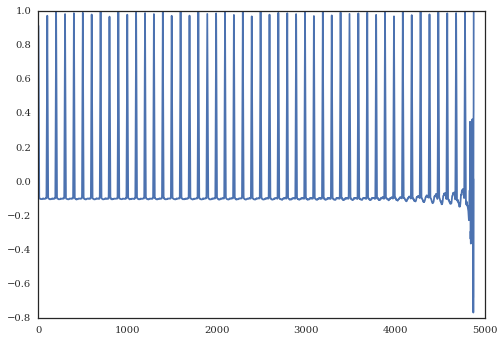

In [125]:
plt.plot(autocorrs)

In [136]:
autocorrs = autocorrs[~np.isnan(autocorrs)]

In [141]:
np.percentile(autocorrs, 99)

0.96589125059331138